## LSH Analysis

Compare predicted and actual variant correlations.

Steps:

- Select a subset of variants to scope evaluation to (optional)
- Load ground-truth pair-wise LD
- Load hashes and determine pair-wise collision
- Analyze results, looking for when collisions start occurring as the true LD increases

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ByteType, IntegerType
from pyspark.sql import functions as F
import os
import pandas as pd
import numpy as np
%run {os.environ['NB_DIR']}/nb.py
%run $BENCHMARK_METHOD_DIR/common.py

ds_name = DATASET_HM
sample_rate = .1
min_ld = .1
eval_sample_rate = .25

# ds_name = DATASET_SIM
# sample_rate = 1
# min_ld = .1
# eval_sample_rate = None

ds_config = DATASET_CONFIG[ds_name]
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
# h, g = 4096, 4
#h, g = 64, 4096
#h, g = 32, 4096
h, g = 28, 16384

### Select Variants

In [4]:
#/tmp/benchmark_datasets/hapmap-sr=0.05.parquet
dfv = spark.read.parquet(dataset_path(ds_name, ext='parquet', sr=sample_rate)).select('row_idx')
if eval_sample_rate is not None:
    dfv = dfv.sample(fraction=eval_sample_rate, seed=1, withReplacement=False)
variants = list(map(int, dfv.toPandas()['row_idx'].unique()))
len(variants)

2664

### Load True Pairwise LD

In [5]:
def get_ld_matrix(rows=None):
    path = dataset_path(ds_name, ext='parquet', sr=sample_rate, minld=min_ld) 
    df = spark.read.parquet(path).withColumnRenamed('entry', 'value')
    if rows is not None:
        df = df.filter(df.i.isin(rows) & df.j.isin(rows))
    return df
dfp = get_ld_matrix(variants)
dfp

DataFrame[i: bigint, j: bigint, value: double]

In [6]:
dfp.count()

476295

In [7]:
dfp.toPandas()['value'].describe()

count    476295.000000
mean          0.150158
std           0.051158
min           0.100000
25%           0.116402
50%           0.137240
75%           0.169508
max           1.000000
Name: value, dtype: float64

### Load Hash Buckets

In [8]:
def get_hashes(h, g, rows=None, remove_singletons=True):
    path = dataset_path(ds_name, ext='parquet', sr=sample_rate, h=h, g=g)
    print(path)
    df = spark.read.parquet(path)
    if rows is not None:
        df = df.filter(df.variant.isin(rows))
    
    # Remove singleton buckets since they imply no pairs
    if remove_singletons:
        cts = df.groupby('hash_bucket').count()
        cts = cts.filter(cts['count'] > 1)
        df = df.join(cts, 'hash_bucket', 'left_semi')
    return df

dfh = get_hashes(h, g, rows=variants, remove_singletons=True)
dfh

/home/eczech/data/gwas/benchmark/datasets/ld_prune/lsh/hapmap-sr=0.1-h=28-g=16384.parquet


DataFrame[hash_bucket: bigint, variant: bigint, hash_group: bigint, hash_value: bigint, index: bigint]

In [9]:
assert dfh.agg(F.countDistinct(dfh['variant']).alias('ct')).select('ct').head(1)[0]['ct'] <= len(variants)

In [10]:
dfh.count()

1882047

### Compute Collisions

In [11]:
def get_hashed_pairs(h, g, **kwargs):
    path = dataset_path(ds_name, sr=sample_rate, h=h, g=g) + '.parquet'
    dfh = get_hashes(h, g, **kwargs)
    
    df1 = dfh.select('variant', 'hash_bucket')\
        .withColumnRenamed('variant', 'i')\
        .withColumnRenamed('hash_bucket', 'i_hb')
    df2 = dfh.select('variant', 'hash_bucket')\
        .withColumnRenamed('variant', 'j')\
        .withColumnRenamed('hash_bucket', 'j_hb')

    df = df1.join(df2, [df1.i_hb == df2.j_hb], how='inner')
    df = df.filter(df.j > df.i) # Upper triangle only
    df = df.groupby(['i', 'j']).count()
    return df

def write_hashed_pairs(h, g, **kwargs):
    df = get_hashed_pairs(h, g, **kwargs)
    path = module_path('analysis', 'hash_pairs', ext='parquet', h=h, g=g)
    df.write.parquet(path, mode='overwrite')
    return path

In [12]:
%%time
path = write_hashed_pairs(h, g, rows=variants, remove_singletons=True)
path

/home/eczech/data/gwas/benchmark/datasets/ld_prune/lsh/hapmap-sr=0.1-h=28-g=16384.parquet
CPU times: user 904 ms, sys: 255 ms, total: 1.16 s
Wall time: 25.5 s


'/home/eczech/data/gwas/benchmark/analysis/ld_prune/lsh/hash_pairs-h=28-g=16384.parquet'

### Merge 

In [13]:
def get_merged_results(dfh, dfp):
    dfh = dfh.withColumnRenamed('count', 'h_count')
    dfp = dfp.withColumnRenamed('value', 'p_value')
    
    df = dfh.join(dfp, ['i', 'j'], how='outer')
    df = df.withColumn(
        'status', 
        F.when(df.h_count.isNull(), 'only_p')
        .when(df.p_value.isNull(), 'only_h')
        .otherwise('both')
    )
    return df
dfm = get_merged_results(spark.read.parquet(path), dfp)
dfm

DataFrame[i: bigint, j: bigint, h_count: bigint, p_value: double, status: string]

In [14]:
df = dfm.toPandas()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476532 entries, 0 to 476531
Data columns (total 5 columns):
i          476532 non-null int64
j          476532 non-null int64
h_count    1445 non-null float64
p_value    476295 non-null float64
status     476532 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 18.2+ MB
None


,i,j,h_count,p_value,status
0,1,5486,NaN,0.150639,only_p
1,7,4635,NaN,0.121675,only_p
2,10,8846,NaN,0.141519,only_p
3,10,9641,NaN,0.173441,only_p
4,12,4589,NaN,0.176680,only_p


In [15]:
df['status'].value_counts()

only_p    475087
both        1208
only_h       237
Name: status, dtype: int64

In [16]:
(df[df['p_value'].notnull()]['p_value'] >= 1).value_counts()

False    476274
True         21
Name: p_value, dtype: int64

In [17]:
df[df['p_value'] >= .9]['status'].value_counts()

both      193
only_p      6
Name: status, dtype: int64

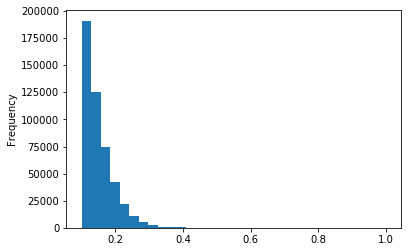

In [19]:
df['p_value'].plot(kind='hist', bins=32)

### Visualize

In [66]:
def get_metrics(df, threshold, step):
    df = df.copy()
    def get_filtered_status(r):
        if pd.isnull(r['p_value']):
            return 'only_h'
        if r['p_value'] < threshold and r['status'] == 'both':
            return 'only_h'
        # Drop this case from further calculations
        if r['p_value'] < threshold and r['status'] == 'only_p':
            return None
        return r['status']
        
    # Calculate integrated statistics 
    df['status'] = df.apply(get_filtered_status, axis=1)
    df = df[df['status'].notnull()]
    cts = df['status'].value_counts().to_dict()
    ntot = len(df)
    nbt = cts.get('both', 0)
    nop = cts.get('only_p', 0)
    noh = cts.get('only_h', 0)
    
    # Calculate interval statistics
    df = df[(df['p_value'] >= threshold) & (df['p_value'] < threshold + step)]
    cts = df['status'].value_counts().to_dict()
    nibt = cts.get('both', 0) 
    niop = cts.get('only_p', 0)
    return dict(
        threshold=threshold,
        n_total=ntot,
        n_both=nbt,
        n_only_p=nop,
        n_only_h=noh,
        precision=nbt / (nbt + noh) if nbt + noh > 0 else 0,
        recall=nbt / (nbt + nop) if nbt + nop > 0 else 0,
        n_int_bt=nibt,
        n_int_op=niop,
        ecp=nibt / (nibt + niop) if nibt + niop > 0 else 0
    )

In [67]:
dfstat = pd.DataFrame([
    pd.Series(get_metrics(df, t, step=.1))
    for t in list(np.arange(.1, 1, step=.1))
]).assign(tcp=lambda df: hash_collision_probability(df['threshold'], h=h, g=g))
path = module_path('analysis', 'stats', ext='csv', ds=ds_name, esr=eval_sample_rate, h=h, g=g)
dfstat.to_csv(path, index=False)
path

'/home/eczech/data/gwas/benchmark/analysis/ld_prune/lsh/stats-ds=hapmap-esr=0.25-h=28-g=16384.csv'

In [68]:
# Hapmap: h, g = 28, 16384
dfstat

,threshold,n_total,n_both,n_only_p,n_only_h,precision,recall,n_int_bt,n_int_op,ecp,tcp
0,0.1,476532.0,1208.0,475087.0,237.0,0.835986,0.002536,282.0,417505.0,0.000675,0.000345
1,0.2,59027.0,926.0,57582.0,519.0,0.640830,0.015827,162.0,52972.0,0.003049,0.001786
2,0.3,6055.0,764.0,4610.0,681.0,0.528720,0.142166,78.0,3777.0,0.020233,0.008700
3,0.4,2278.0,686.0,833.0,759.0,0.474740,0.451613,65.0,585.0,0.100000,0.040377
4,0.5,1693.0,621.0,248.0,824.0,0.429758,0.714614,77.0,187.0,0.291667,0.174900
5,0.6,1506.0,544.0,61.0,901.0,0.376471,0.899174,137.0,35.0,0.796512,0.598995
6,0.7,1471.0,407.0,26.0,1038.0,0.281661,0.939954,124.0,20.0,0.861111,0.990130
7,0.8,1451.0,283.0,6.0,1162.0,0.195848,0.979239,90.0,0.0,1.000000,1.000000
8,0.9,1451.0,193.0,6.0,1252.0,0.133564,0.969849,172.0,6.0,0.966292,1.000000


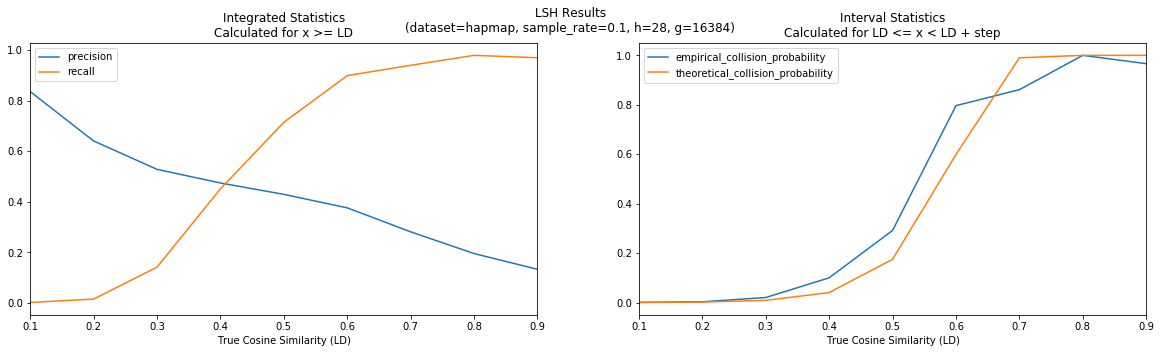

In [86]:
def plot_stats(df):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    df.set_index('threshold')[['precision', 'recall']].plot(
        ax=axs[0], title='Integrated Statistics\nCalculated for x >= LD')
    df.set_index('threshold')[['ecp', 'tcp']].rename(columns={
        'ecp': 'empirical_collision_probability',
        'tcp': 'theoretical_collision_probability'
    }).plot(ax=axs[1], title='Interval Statistics\nCalculated for LD <= x < LD + step')
    for ax in axs:
        ax.set_xlabel('True Cosine Similarity (LD)')
    fig.suptitle(f'LSH Results\n(dataset={ds_name}, sample_rate={sample_rate}, h={h}, g={g})')
plot_stats(dfstat)

In [21]:
# HapMap: h, g = 64, 4096
pd.DataFrame([
    pd.Series(get_metrics(df, t))
    for t in list(np.linspace(.1, .9, 9)) + [.95]
])

,threshold,n_total,n_both,n_only_p,n_only_h,precision,recall
0,0.10,476295.0,155.0,476140.0,0.0,1.000000,0.000325
1,0.20,58508.0,155.0,58353.0,0.0,1.000000,0.002649
2,0.30,5374.0,155.0,5219.0,0.0,1.000000,0.028843
3,0.40,1519.0,155.0,1364.0,0.0,1.000000,0.102041
4,0.50,869.0,155.0,714.0,0.0,1.000000,0.178366
5,0.60,605.0,155.0,450.0,0.0,1.000000,0.256198
6,0.70,433.0,155.0,278.0,0.0,1.000000,0.357968
7,0.80,289.0,155.0,134.0,0.0,1.000000,0.536332
8,0.90,200.0,154.0,45.0,1.0,0.993548,0.773869
9,0.95,179.0,127.0,24.0,28.0,0.819355,0.841060
